In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from Backtesting import stats, portfolio

In [2]:
def signal_generation(asset, initial_acceleration, step_acceleration, end_acceleration):

    signals = pd.DataFrame()
    signals['asset'] = asset['Close']
    signals['trend'] = np.nan
    signals['sar'] = np.nan
    signals['ep'] = np.nan
    signals['acceleration'] = np.nan
    signals['positions'] = 0
    signals['signals'] = 0

    signals.at[signals.index[1], 'trend'] = 1 if signals['asset'].iloc[1] > signals['asset'].iloc[0] else -1
    signals.at[signals.index[1], 'sar'] = asset['High'].iloc[0] if signals['trend'].iloc[1] > 0 else asset['Low'].iloc[0]
    signals.at[signals.index[1], 'ep'] = asset['High'].iloc[1] if signals['trend'].iloc[1] > 0 else asset['Low'].iloc[1]
    signals.at[signals.index[1], 'acceleration'] = initial_acceleration

    for i in range(2, len(signals)):
        
        signals.at[signals.index[i], 'sar'] = signals['sar'].iloc[i-1] + signals['acceleration'].iloc[i-1] * (signals['ep'].iloc[i-1] - signals['sar'].iloc[i-1])
        
        if signals['trend'].iloc[i-1] < 0:
            signals.at[signals.index[i], 'sar'] = max(signals['sar'].iloc[i], asset['High'].iloc[i-1], asset['High'].iloc[i-2])

            # Trend reversal
            if signals['sar'].iloc[i] < asset['High'].iloc[i]:
                signals.at[signals.index[i], 'trend'] = 1
                signals.at[signals.index[i], 'sar'] = signals['ep'].iloc[i-1]
                signals.at[signals.index[i], 'acceleration'] = initial_acceleration
                signals.at[signals.index[i], 'ep'] = asset['High'].iloc[i]
            else:
                signals.at[signals.index[i], 'trend'] = -1
                signals.at[signals.index[i], 'ep'] = min(asset['Low'].iloc[i], signals['ep'].iloc[i-1])
        else:
            signals.at[signals.index[i], 'sar'] = min(signals['sar'].iloc[i], asset['Low'].iloc[i-1], asset['Low'].iloc[i-2])
            
            # Trend reversal
            if signals['sar'].iloc[i] > asset['Low'].iloc[i]:
                signals.at[signals.index[i], 'trend'] = -1
                signals.at[signals.index[i], 'sar'] = signals['ep'].iloc[i-1]
                signals.at[signals.index[i], 'acceleration'] = initial_acceleration
                signals.at[signals.index[i], 'ep'] = asset['Low'].iloc[i]
            else:
                signals.at[signals.index[i], 'trend'] = 1
                signals.at[signals.index[i], 'ep'] = max(asset['High'].iloc[i], signals['ep'].iloc[i-1])
        
        # Acceleration update
        if signals['trend'].iloc[i] == signals['trend'].iloc[i-1]:
            if signals['ep'].iloc[i] == signals['ep'].iloc[i-1]:
                signals.at[signals.index[i], 'acceleration'] = signals['acceleration'].iloc[i-1]
            else:
                signals.at[signals.index[i], 'acceleration'] = min(end_acceleration, signals['acceleration'].iloc[i-1] + step_acceleration)

    signals['positions'] = np.where(signals['sar'] < signals['asset'], 1, 0)
    signals.at[signals.index[0], 'positions'] = 0
    signals['signals'] = signals['positions'].diff()

    return signals


In [3]:
def plot(signals, ticker):
    
    # Long/short signals
    plt.figure(figsize=(11,7))
    plt.plot(signals['asset'], label=ticker, alpha=0.8, color='C0')
    plt.plot(signals['asset'][signals['signals']>0], lw=0, marker='^', markersize=7, c='g', alpha=0.6, label='LONG')
    plt.plot(signals['asset'][signals['signals']<0], lw=0, marker='v', markersize=7, c='r', alpha=0.6, label='SHORT')
    plt.legend(loc='upper left')
    plt.xlabel('Date', labelpad=15)
    plt.ylabel(ticker, labelpad=15)
    plt.title('Parabolic SAR', pad=15)
    plt.grid(True)
    plt.show()
    
    # SAR line
    plt.figure(figsize=(11,7))
    plt.plot(signals['asset'], color='C0', alpha=0.8, label=ticker)
    plt.plot(signals['sar'], linestyle=':', color='C1', alpha=0.8, label='SAR')
    plt.xlabel('Date', labelpad=15)
    plt.ylabel('Price', labelpad=15)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.title('Parabolic SAR', pad=15)
    plt.show()

In [4]:
def ParabolicSAR(ticker, start_date, end_date, capital):
    asset = yf.download(ticker, start=start_date, end=end_date, progress=False)

    # Default acceleration parameters
    signals = signal_generation(asset, 0.02, 0.01, 0.2)
    
    plot(signals, ticker)
    return stats(portfolio(signals, capital, 'Parabolic SAR'), signals, start_date, end_date, capital)

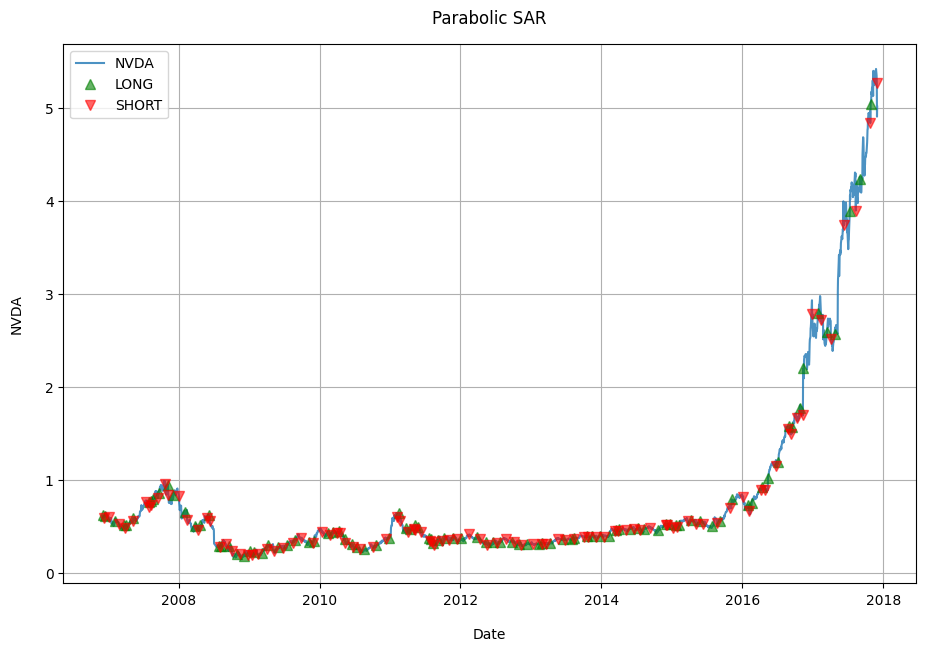

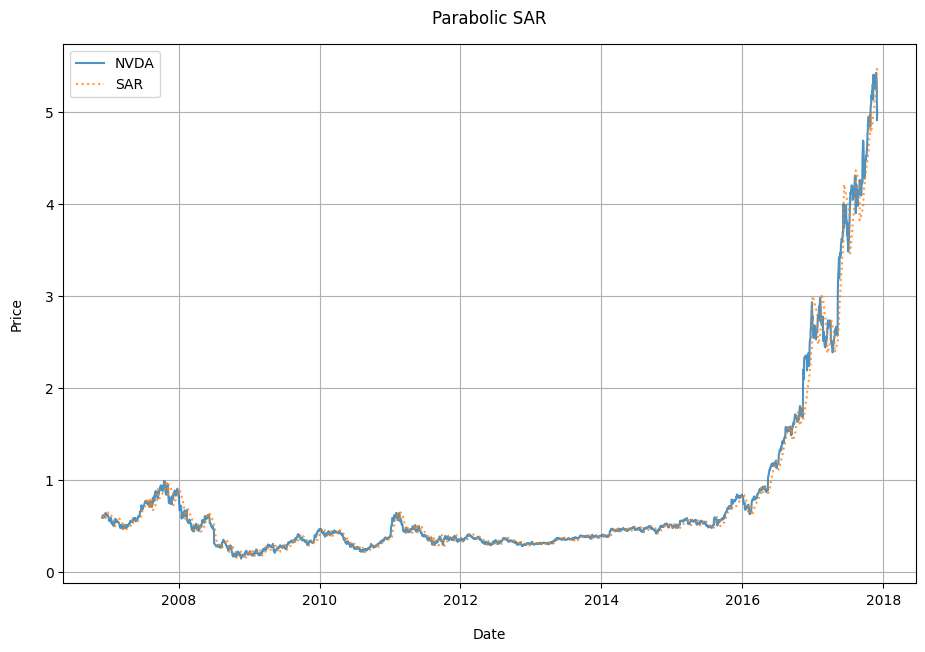

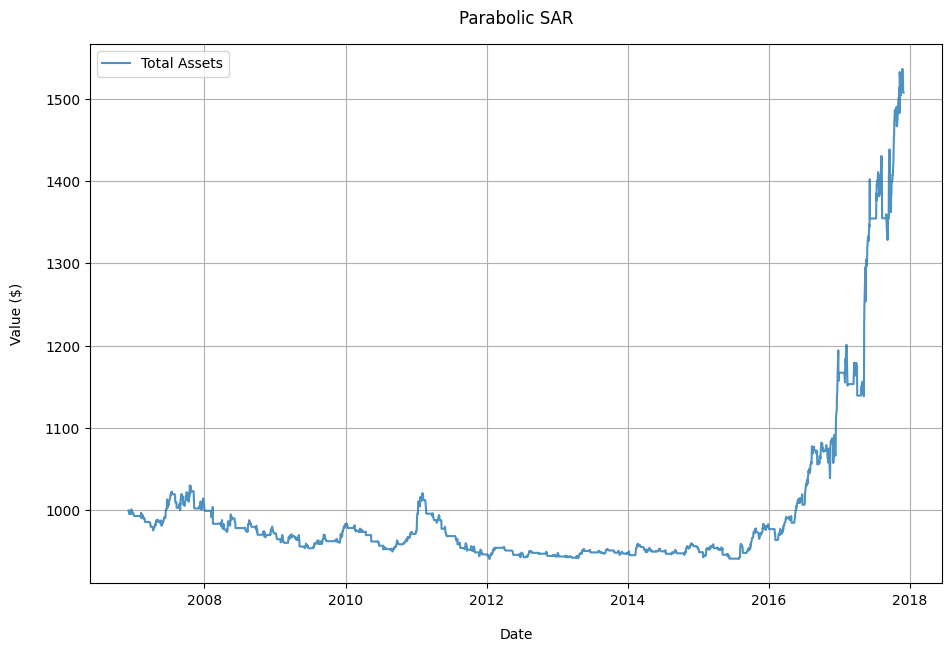

,portfolio return,benchmark return,growth rate,sharpe ratio,maximum drawdown,calmar ratio,avg trade length,profit per trade
0,0.507328,0.890278,0.000148,-0.02171,-0.086603,-0.001711,7.719388,2.588409


In [5]:
ParabolicSAR('NVDA', '2006-12-01', '2017-12-01', 1000)